In [2]:
import pandas as pd
import numpy as np
import r2pipe as r2
from tqdm import tqdm

In [3]:
CPU_ARCH = "x86_64"
SUPPORT_SHOTS = 5 # number of samples per class to use as support for training
QUERY_SHOTS = 5 # number of samples per class to use as query for training
SUPPORT_SHOTS_VA = 5 # number of samples per class to use as support for validation
QUERY_SHOTS_VA = 5 # number of samples per class to use as query for validation
N_GRAM_1 = 2
N_GRAM_2 = 4
N_WAYS = 10
# NUM_EXAMPLES = 200
NUM_EXAMPLES_TEST = 30
BYTE_LENGTH = 2000
EPOCHS = 100
LEARNING_RATE = 0.001
LR_SCHEDULER_STEP = 20
LR_SCHEDULER_GAMMA = 0.5
ITERATIONS = 100 # number of episodes per epoch
CLASS_PER_ITER_TR = 5 # number of random classes per episode for training
CLASS_PER_ITER_VA = 5 # number of random classes per episode for validation
SEED = 7 # random seed
ADDITIONAL_INFO = "_rm_dup"
MODEL_NAME = f"exp_cluster_before_1{ADDITIONAL_INFO}"
CUDA = False
TRAIN = False
PROTOTYPE_BY_TRAIN = False
VALIDATION = False
VAL_PROTOTYPE_BY_TRAIN = False

In [4]:
# load dataset
DATASET_PATH = f"./dataset/malware_original_x86_64_byte_sequence{BYTE_LENGTH}_split{ADDITIONAL_INFO}.csv"
DATASET_FOLDER = "/home/mandy900619/data/Malware202403/"
PIC_PATH = "./pic/"
MODEL_PATH = "./models/"
LOG_PATH = "./logs/"
CPU_ARCH = "x86_64"
EMBEDDING_PATH = "./dataset_embedding/"    


In [5]:
import pickle

print("Loading Data...")

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_label_mapping{ADDITIONAL_INFO}.pickle", "rb") as f:
    label_mapping = pickle.load(f)
    f.close()

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_tfidf_vec_train{ADDITIONAL_INFO}.pickle", "rb") as f:
    tfidf_matrix_train = pickle.load(f)
    f.close()

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_tfidf_vec_test{ADDITIONAL_INFO}.pickle", "rb") as f:
    tfidf_matrix_test = pickle.load(f)
    f.close()
if VALIDATION:
    with open(f"{EMBEDDING_PATH}{CPU_ARCH}_tfidf_vec_val{ADDITIONAL_INFO}.pickle", "rb") as f:
        tfidf_matrix_val = pickle.load(f)
        f.close()

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_y_train{ADDITIONAL_INFO}.pickle", "rb") as f:
    y_train = pickle.load(f)
    f.close()

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_y_test{ADDITIONAL_INFO}.pickle", "rb") as f:
    y_test = pickle.load(f)
    f.close()
if VALIDATION:
    with open(f"{EMBEDDING_PATH}{CPU_ARCH}_y_val{ADDITIONAL_INFO}.pickle", "rb") as f:
        y_val = pickle.load(f)
        f.close()

Loading Data...


In [6]:
print(f"Training set shape: {tfidf_matrix_train.shape}")
print(f"Testing set shape: {tfidf_matrix_test.shape}")
if VALIDATION:
    print(f"Validation set shape: {tfidf_matrix_val.shape}")
print(f"Label mapping: {label_mapping}")

Training set shape: (1000, 1000)
Testing set shape: (300, 1000)
Label mapping: {0: 'camelot', 1: 'dropperl', 2: 'gafgyt', 3: 'mirai', 4: 'rekoobe', 5: 'sliver', 6: 'sshdoor', 7: 'tsunami', 8: 'vtflooder', 9: 'xmrig'}


### Experiment_Prototype Learning_1


In [7]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [8]:
if torch.cuda.is_available() and not CUDA:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

torch.cuda.cudnn_enabled = False
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(SEED)

In [9]:
import torch.nn as nn

def linear_block(input_size, output_size, batch_norm=True, dropout_prob=0.5):
    layers = [nn.Linear(input_size, output_size)]
    if batch_norm:
        layers.append(nn.BatchNorm1d(output_size))
    layers.append(nn.ReLU())
    if dropout_prob > 0:
        layers.append(nn.Dropout(dropout_prob))
    return layers

class ByteSequenceEmbedding(nn.Module): # Can revise
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(ByteSequenceEmbedding, self).__init__()
        self.layers = nn.Sequential(
            *linear_block(input_size, hidden_size, batch_norm=True, dropout_prob=dropout_prob),
            *linear_block(hidden_size, hidden_size, batch_norm=True, dropout_prob=dropout_prob),
            *linear_block(hidden_size, output_size, batch_norm=False, dropout_prob=0)
        )


    def forward(self, x):
        return self.layers(x)


In [10]:
import torch 
import torch.nn.functional as F
from scipy.spatial import distance

class PrototypeNet(nn.Module):
    def __init__(self, embedding_model):
        super(PrototypeNet, self).__init__()
        self.embedding_model = embedding_model

    def forward(self, x):
        x = self.embedding_model(x)
        return x.view(x.size(0), -1)


In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Sampler

class ByteSequenceSampler(Sampler):
    def __init__(self, labels, n_shot, classes_per_iter, iterations):
        self.labels = labels
        self.n_shot = n_shot
        self.classes_per_iter = classes_per_iter
        self.iterations = iterations

        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.classes = torch.LongTensor(self.classes)

        self.indexes = np.empty((len(self.classes), max(self.counts)), dtype=int) * np.nan
        # 15, 20
        self.indexes = torch.tensor(self.indexes)
        self.numel_per_class = torch.zeros_like(self.classes)

        for idx, label in enumerate(self.labels):
            label_idx = np.argwhere(self.classes == label).item()
            self.indexes[label_idx, np.where(np.isnan(self.indexes[label_idx]))[0][0]] = idx
            self.numel_per_class[label_idx] += 1
    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        spc = self.n_shot
        cpi = self.classes_per_iter

        for it in range(self.iterations):
            batch_size = spc * cpi
            batch = torch.LongTensor(batch_size)
            c_idxs = torch.randperm(len(self.classes))[:cpi]
            for i, c in enumerate(self.classes[c_idxs]):
                s = slice(i * spc, (i + 1) * spc)
                # FIXME when torch.argwhere will exists
                label_idx = torch.arange(len(self.classes)).long()[self.classes == c].item()
                sample_idxs = torch.randperm(self.numel_per_class[label_idx])[:spc]
                batch[s] = self.indexes[label_idx][sample_idxs]
            batch = batch[torch.randperm(len(batch))]
            yield batch

    
    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations


In [12]:
import torch
from torch.nn import functional as F
from torch.nn.modules import Module

class PrototypicalLoss(Module):
    '''
    Loss class deriving from Module for the prototypical loss function defined below
    '''
    def __init__(self, n_support):
        super(PrototypicalLoss, self).__init__()
        self.n_support = n_support

    def forward(self, input, target):
        return prototypical_loss(input, target, self.n_support)   

def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

def prototypical_loss(input, target, n_support):
    '''
    Inspired by https://github.com/jakesnell/prototypical-networks/blob/master/protonets/models/few_shot.py

    Compute the barycentres by averaging the features of n_support
    samples for each class in target, computes then the distances from each
    samples' features to each one of the barycentres, computes the
    log_probability for each n_query samples for each one of the current
    classes, of appartaining to a class c, loss and accuracy are then computed
    and returned
    Args:
    - input: the model output for a batch of samples
    - target: ground truth for the above batch of samples
    - n_support: number of samples to keep in account when computing
      barycentres, for each one of the current classes
    '''
    target_cpu = target.to('cpu')
    input_cpu = input.to('cpu')

    def supp_idxs(c):
        # FIXME when torch will support where as np
        return target_cpu.eq(c).nonzero()[:n_support].squeeze(1)

    # FIXME when torch.unique will be available on cuda too
    classes = torch.unique(target_cpu)
    n_classes = len(classes)
    # FIXME when torch will support where as np
    # assuming n_query, n_target constants
    n_query = target_cpu.eq(classes[0].item()).sum().item() - n_support

    support_idxs = list(map(supp_idxs, classes))

    prototypes = torch.stack([input_cpu[idx_list].mean(0) for idx_list in support_idxs])

    # FIXME when torch will support where as np
    query_idxs = torch.stack(list(map(lambda c: target_cpu.eq(c).nonzero()[n_support:], classes))).view(-1)

    query_samples = input.to('cpu')[query_idxs]
    dists = euclidean_dist(query_samples, prototypes)

    log_p_y = F.log_softmax(-dists, dim=1).view(n_classes, n_query, -1)

    target_inds = torch.arange(0, n_classes)
    target_inds = target_inds.view(n_classes, 1, 1)
    target_inds = target_inds.expand(n_classes, n_query, 1).long()

    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = y_hat.eq(target_inds.squeeze(2)).float().mean()
    
    return loss_val,  acc_val, prototypes, classes, query_samples, target_inds, y_hat, log_p_y


def prototypical_loss_using_proto(input, target, prototypes):
    # 修改原本的model使其不使用testing data計算prototypes
    target_cpu = target.to('cpu')
    input_cpu = input.to('cpu')

    classes = torch.unique(target_cpu)
    n_classes = len(classes)

    # prototypes is dict
    prototypes_torch = torch.tensor([])
    for key in prototypes:
        prototypes_torch = torch.cat((prototypes_torch, prototypes[key].unsqueeze(0)), 0)
    dists = euclidean_dist(input_cpu, prototypes_torch)

    log_p_y = F.log_softmax(-dists, dim=1)
    loss_val = -log_p_y.gather(1, target_cpu.view(-1, 1)).squeeze().mean()
    _, y_hat = log_p_y.max(1)    

    acc_val = y_hat.eq(target_cpu).float().mean()
    
    return loss_val, acc_val, y_hat, log_p_y


In [13]:
from sklearn.metrics import accuracy_score


def train(model, dataloader, support_shots, optim,lr_scheduler , exp_name="default", save_model=False, val_dataloader=None):
    if val_dataloader is None:
        best_state = None
    
    loss_min = 100
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    best_acc = 0

    for epoch in range(EPOCHS):
        print('=== Epoch: {} ==='.format(epoch))
        model.train()
        prototypes = dict()
        prototypesCounts = dict()
        for i, (data, labels) in enumerate(dataloader):
            optim.zero_grad()
            data = data.squeeze(1)
            data = data.float()
            embeddings = model(data)
            loss, acc, proto, protoID, _, _, _, _ = prototypical_loss(embeddings, target=labels, n_support=support_shots)
            if PROTOTYPE_BY_TRAIN:
                for i in range(proto.shape[0]):
                    if prototypesCounts.get(protoID[i].item()) is None:
                        prototypesCounts[protoID[i].item()] = 1
                        prototypes[protoID[i].item()] = proto[i]
                    else:
                        prototypesCounts[protoID[i].item()] += 1
                        prototypes[protoID[i].item()] += proto[i]
            loss.backward()
            optim.step()   
            train_loss.append(loss.item())
            train_acc.append(acc.item()) 
        prototypes = {k: v / prototypesCounts[k] for k, v in prototypes.items()}
        prototypes = dict(sorted(prototypes.items()))
        avg_loss = np.mean(train_loss[-(ITERATIONS):])
        avg_acc = np.mean(train_acc[-(ITERATIONS):])
        print('Avg Train Loss: {}, Avg Train Acc: {}'.format(avg_loss, avg_acc))
        lr_scheduler.step()
        if val_dataloader is not None:
            model.eval()
            for i, (data, labels) in enumerate(val_dataloader):
                data = data.squeeze(1)
                data = data.float()
                model_output = model(data)
                if VAL_PROTOTYPE_BY_TRAIN:
                    loss, acc, _, _ = prototypical_loss_using_proto(model_output, target=labels, prototypes=prototypes)
                else:
                    loss, acc, _, _, _, _, _, _ = prototypical_loss(model_output, target=labels, n_support=support_shots)
                val_loss.append(loss.item())
                val_acc.append(acc.item())
            avg_loss = np.mean(val_loss[-(ITERATIONS):])
            avg_acc = np.mean(val_acc[-(ITERATIONS):])
            postfix = ' (Best)' if avg_acc >= best_acc else ' (Best: {})'.format(
                best_acc)
            print('Avg Val Loss: {}, Avg Val Acc: {}{}'.format(
                avg_loss, avg_acc, postfix))
        if save_model and avg_acc >= best_acc:
            torch.save(model.state_dict(), f"./models/model_{exp_name}.pt")
            best_acc = avg_acc
            best_state = model.state_dict()
        if save_model:
            torch.save(model.state_dict(), f"./models/model_{exp_name}_check_point.pt")

    return best_state, best_acc, train_loss, train_acc, val_loss, val_acc



In [14]:
# Train the model

data_tensor = torch.tensor(tfidf_matrix_train)
label_tensor = torch.tensor(y_train)
trainDataset = TensorDataset(data_tensor, label_tensor)

sampler = ByteSequenceSampler(y_train, SUPPORT_SHOTS + QUERY_SHOTS, CLASS_PER_ITER_TR, ITERATIONS) # support + query
trainLoader = DataLoader(trainDataset, batch_sampler=sampler)

embedding_model = ByteSequenceEmbedding(data_tensor.shape[1], 64, 64)
if VALIDATION:
    val_data_tensor = torch.tensor(tfidf_matrix_val)
    val_label_tensor = torch.tensor(y_val)
    valDataset = TensorDataset(val_data_tensor, val_label_tensor)
    val_sampler = ByteSequenceSampler(y_val, SUPPORT_SHOTS_VA + QUERY_SHOTS_VA, CLASS_PER_ITER_VA, ITERATIONS) # support + query
    valLoader = DataLoader(valDataset, batch_sampler=val_sampler)

model = PrototypeNet(embedding_model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_SCHEDULER_STEP, gamma=LR_SCHEDULER_GAMMA)
if VALIDATION == False:
    valLoader = None
if TRAIN == True:
    train(model, trainLoader, support_shots = SUPPORT_SHOTS, optim = optimizer, exp_name=MODEL_NAME, save_model=True, lr_scheduler=lr_scheduler, val_dataloader=valLoader)

/home/mandy900619/Tools/Anaconda/envs/byteSequence/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [15]:
model.load_state_dict(torch.load(f"./models/model_{MODEL_NAME}.pt"))

def get_prototypes(model, dataloader, support_shots):
    '''
    Get the prototypes for each class
    '''
    model.eval()
    prototypes = dict()
    prototypesCounts = dict()
    for idx, (data, labels) in enumerate(dataloader):
        data = data.squeeze(1)
        data = data.float()
        model_output = model(data)
        _, _, proto, protoID, _, _, _, _ = prototypical_loss(model_output, target=labels, n_support=support_shots)

        for i in range(proto.shape[0]):
            if prototypesCounts.get(protoID[i].item()) is None:
                prototypesCounts[protoID[i].item()] = 1
                prototypes[protoID[i].item()] = proto[i]
            else:
                prototypesCounts[protoID[i].item()] += 1
                prototypes[protoID[i].item()] += proto[i]
    prototypes = {k: v / prototypesCounts[k] for k, v in prototypes.items()}
    # sort the prototypes by key
    prototypes = dict(sorted(prototypes.items()))
    print(prototypes.keys())
    return prototypes

if PROTOTYPE_BY_TRAIN == True:
    prototypes = get_prototypes(model, trainLoader, SUPPORT_SHOTS) 

In [16]:

def test(test_dataloader, model, support_shots=SUPPORT_SHOTS_VA, prototypes=None):
    '''
    Test the model trained with the prototypical learning algorithm
    '''
    device = 'cuda:0' if torch.cuda.is_available() and CUDA else 'cpu'
    avg_acc = list()
    for epoch in range(10):
        test_iter = iter(test_dataloader)
        for batch in test_iter:
            x, y = batch
            x, y = x.to(device), y.to(device)
            x = x.squeeze(1)
            x = x.float()
            model_output = model(x)
            if prototypes is not None:
                _, acc, _, _ = prototypical_loss_using_proto(model_output, target=y,prototypes=prototypes)
            else:
                _, acc, _, _, _, _, _, _ = prototypical_loss(model_output, target=y, n_support=support_shots)
            avg_acc.append(acc.item())
            #print(set(y.cpu().numpy()))
            #print('Test Acc: {}'.format(acc.item()))
    avg_acc = np.mean(avg_acc)
    print('Test Acc: {}'.format(avg_acc))

    return avg_acc
def eval():
    '''
    Initialize everything and train
    '''
    if torch.cuda.is_available() and not CUDA:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

    data_tensor = torch.tensor(tfidf_matrix_test)
    label_tensor = torch.tensor(y_test)

    trainDataset = TensorDataset(data_tensor, label_tensor)

    sampler = ByteSequenceSampler(y_test, SUPPORT_SHOTS_VA + QUERY_SHOTS_VA, N_WAYS, ITERATIONS) # support + query

    testLoader = DataLoader(trainDataset, batch_sampler=sampler)
    embedding_model = ByteSequenceEmbedding(data_tensor.shape[1], 64, 64)       
    model = PrototypeNet(embedding_model)

    model.load_state_dict(torch.load(f"./models/model_{MODEL_NAME}.pt"))
    model.eval()
    
    if PROTOTYPE_BY_TRAIN == True:
        test(test_dataloader=testLoader,model=model,prototypes=prototypes)
    else:
        test(test_dataloader=testLoader,model=model)

In [17]:
# Test the model

eval()

Test Acc: 0.9632999993562699


In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from textwrap import wrap

def visualize_embeddings(prototypes, query_embeddings, n_way, n_query, query_labels, label_mapping, pred_y):
    prototypes_np = prototypes.detach().numpy()
    # print(prototypes_np.shape)
    pred_y = pred_y.reshape(-1)
    try:
        query_labels = query_labels.squeeze(2)
        query_labels = query_labels.reshape(-1)
        query_embeddings_ = query_embeddings
        # query_embeddings_ = query_embeddings[torch.argsort(query_labels)]
        query_embeddings_np = query_embeddings_.detach().numpy()
    except:
        # query_embeddings_ = query_embeddings[torch.argsort(query_labels)]
        query_embeddings_ = query_embeddings
        query_embeddings_np = query_embeddings_.detach().numpy()
    # print(query_embeddings_np.shape)
    # Combine prototypes and query embeddings for t-SNE
    combined_embeddings = np.vstack((prototypes_np, query_embeddings_np))
    tsne = TSNE(n_components=2, random_state=SEED)
    embeddings_2d = tsne.fit_transform(combined_embeddings)
    # print(embeddings_2d.shape)
    # Separate the transformed embeddings
    prototypes_2d = embeddings_2d[:n_way]
    query_embeddings_2d = embeddings_2d[n_way:]
    # print(prototypes_2d.shape)
    # print(query_embeddings_2d.shape)
    cmap = plt.get_cmap("tab20")
    
    # Plotting
    plt.figure(figsize=(14, 8))

    print(query_embeddings_2d.shape)
    for i in label_mapping.keys():
        plt.scatter(prototypes_2d[i, 0], prototypes_2d[i, 1], marker='X', s=200, color=cmap(i), edgecolors='black', linewidth=0.5, label="\n".join(wrap(f'Prototype {label_mapping[i]}', 20)))
        plt.scatter(query_embeddings_2d[i*n_query:(i+1)*n_query, 0], query_embeddings_2d[i*n_query:(i+1)*n_query, 1],marker='o', facecolors='None', color=cmap(i),linewidths=0.5,  label="\n".join(wrap(f'Query {label_mapping[i]}', 20)))
        # print index
        # for j in range(n_query):
        #     plt.text(query_embeddings_2d[i*n_query+j, 0], query_embeddings_2d[i*n_query+j, 1], str(i*n_query + j), fontsize=8)
    for i in range(query_labels.shape[0]):
        if query_labels[i] != pred_y[i]:
            print(f"Query {query_labels[i]} is misclassified as {pred_y[i]} at index {i}")
            plt.scatter(query_embeddings_2d[i, 0], query_embeddings_2d[i, 1], marker='x', s=100, color=cmap(pred_y[i]), linewidth=0.5)


    plt.grid(True)
    plt.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')
    plt.title('t-SNE Visualization of Prototypes and Queries')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig(f"{PIC_PATH}tsne_{MODEL_NAME}.png", dpi=300, bbox_inches='tight')
    plt.show()

torch.Size([10, 64])
torch.Size([250, 64])
(250, 2)
Query 2 is misclassified as 5 at index 58
Query 2 is misclassified as 3 at index 70
Query 3 is misclassified as 7 at index 80
Query 3 is misclassified as 8 at index 82
Query 3 is misclassified as 2 at index 88
Query 3 is misclassified as 2 at index 93
Query 4 is misclassified as 0 at index 108
Query 6 is misclassified as 7 at index 153
Query 6 is misclassified as 0 at index 165
Query 7 is misclassified as 2 at index 193
Query 7 is misclassified as 2 at index 198
Query 9 is misclassified as 0 at index 228
Query 9 is misclassified as 0 at index 229
Query 9 is misclassified as 0 at index 233
Query 9 is misclassified as 0 at index 235
Query 9 is misclassified as 0 at index 236
Query 9 is misclassified as 5 at index 240
Query 9 is misclassified as 0 at index 243
Query 9 is misclassified as 0 at index 246


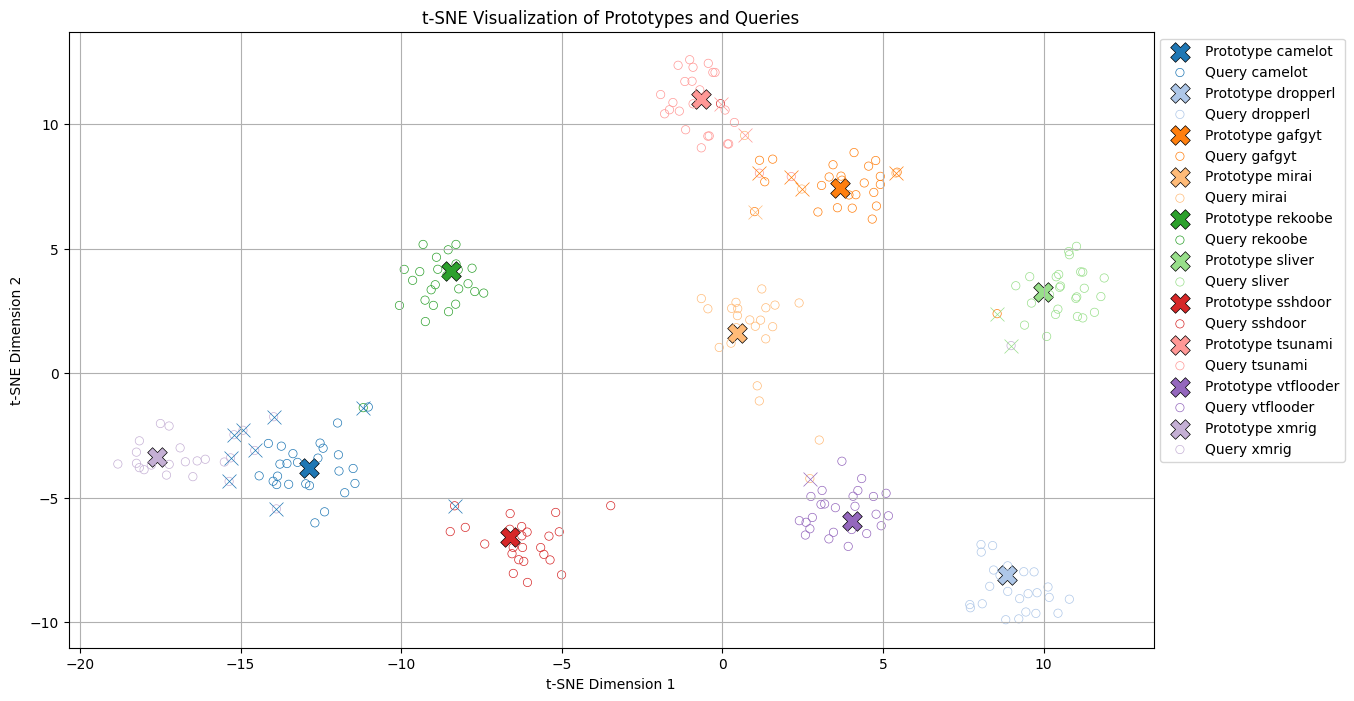

In [19]:
# print tsne
model.load_state_dict(torch.load(f"./models/model_{MODEL_NAME}.pt"))

data_tensor = torch.tensor(tfidf_matrix_test)
label_tensor = torch.tensor(y_test)
embeddings = model(data_tensor.float())

if PROTOTYPE_BY_TRAIN == True:
    prototypes_torch = torch.tensor([])
    for key in prototypes:
        prototypes_torch = torch.cat((prototypes_torch, prototypes[key].unsqueeze(0)), 0)
    n_query = NUM_EXAMPLES_TEST
    query_embeddings = embeddings
    target_inds = label_tensor
else:
    _, _, prototypes_torch, _, query_embeddings, target_inds, pred_y, _ = prototypical_loss(embeddings, target=label_tensor, n_support=SUPPORT_SHOTS_VA)
    print(prototypes_torch.shape)
    print(query_embeddings.shape)
    n_query = NUM_EXAMPLES_TEST - SUPPORT_SHOTS

visualize_embeddings(prototypes_torch, query_embeddings, N_WAYS, n_query, query_labels=target_inds, label_mapping=label_mapping, pred_y=pred_y)

In [20]:
# print confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [v for k, v in classes.items()]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(f"{PIC_PATH}conMatrix_{MODEL_NAME}.png", dpi=300, bbox_inches='tight')
    plt.show()



tensor(0.9240)
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.92 0.04 0.   0.04 0.   0.   0.   0.  ]
 [0.   0.   0.08 0.84 0.   0.   0.   0.04 0.04 0.  ]
 [0.04 0.   0.   0.   0.96 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.04 0.   0.   0.   0.   0.   0.92 0.04 0.   0.  ]
 [0.   0.   0.08 0.   0.   0.   0.   0.92 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.28 0.   0.   0.   0.   0.04 0.   0.   0.   0.68]]


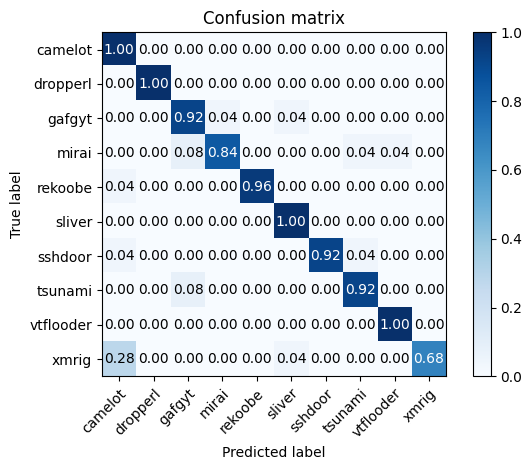

In [21]:
if PROTOTYPE_BY_TRAIN == False:
    loss_val,  acc_val, prototypes, classes, query_samples, target_inds, pred_y, prob = prototypical_loss(embeddings, target=label_tensor, n_support=SUPPORT_SHOTS_VA)
    target_inds_ = target_inds.squeeze(2)
    target_inds_ = target_inds_.reshape(-1)
    print(acc_val)
else:
    _, acc, pred_y, prob = prototypical_loss_using_proto(query_embeddings, target=label_tensor, prototypes=prototypes)
    target_inds_ = label_tensor
    with open(f"{EMBEDDING_PATH}{CPU_ARCH}_prototypes_before_cluster.pickle", "wb") as f:
        pickle.dump(prototypes, f)
        f.close()
    print(acc)

pred_y = pred_y.reshape(-1)
plot_confusion_matrix(target_inds_, pred_y, label_mapping, normalize=True, title='Confusion matrix')

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_probability_before_cluster{ADDITIONAL_INFO}.pickle", "wb") as f:
    pickle.dump(prob, f)
    f.close()

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_pred_y_before_cluster{ADDITIONAL_INFO}.pickle", "wb") as f:
    pickle.dump(pred_y, f)
    f.close()


### Experiment_Machine Learning_1

In [32]:
print(f"Training dataset shape: {tfidf_matrix_train.shape}")
print(f"Labels shape: {y_train.shape}")
print(f"Test dataset shape: {tfidf_matrix_test.shape}")
print(f"Labels shape: {y_test.shape}")

Training dataset shape: (1000, 1000)
Labels shape: (1000,)
Test dataset shape: (300, 1000)
Labels shape: (300,)


In [33]:
# machine learning model
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


# Shuffle the dataset
tfidf_matrix_train, y_train = shuffle(tfidf_matrix_train, y_train, random_state=SEED)
tfidf_matrix_test, y_test = shuffle(tfidf_matrix_test, y_test, random_state=SEED)


svm_classifier = LinearSVC()
knn_classifier = KNeighborsClassifier()
nb_classifier =  MultinomialNB()
mlp_classifier = MLPClassifier(max_iter=1000, hidden_layer_sizes=(50, 50), random_state=SEED)

# with grid search

svm_param_grid = {'C': [0.1, 0.2, 0.5, 1.0, 2.0]}
knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
nb_param_grid = {'alpha': [0.5, 1.0, 1.5, 2.0]}


# 定義 GridSearchCV
svm_grid_search = GridSearchCV(svm_classifier, svm_param_grid, cv=5, scoring='accuracy', n_jobs=20)
svm_grid_search.fit(tfidf_matrix_train, y_train)
print("Best SVM Params:", svm_grid_search.best_params_)
print("Best SVM Accuracy:", svm_grid_search.best_score_)

knn_grid_search = GridSearchCV(knn_classifier, knn_param_grid, cv=5, scoring='accuracy', n_jobs=20)
knn_grid_search.fit(tfidf_matrix_train, y_train)
print("Best KNN Params:", knn_grid_search.best_params_)
print("Best KNN Accuracy:", knn_grid_search.best_score_)

nb_grid_search = GridSearchCV(nb_classifier, nb_param_grid, cv=5, scoring='accuracy', n_jobs=20)
nb_grid_search.fit(tfidf_matrix_train, y_train)
print("Best NB Params:", nb_grid_search.best_params_)
print("Best NB Accuracy:", nb_grid_search.best_score_)


# 使用最佳參數進行預測並評估模型
best_svm = svm_grid_search.best_estimator_
best_knn = knn_grid_search.best_estimator_
best_nb = nb_grid_search.best_estimator_


svm_classifier.fit(tfidf_matrix_train, y_train)
print("SVM Accuracy:", accuracy_score(y_test, svm_classifier.predict(tfidf_matrix_test)))   

knn_classifier.fit(tfidf_matrix_train, y_train)
print("KNN Accuracy:", accuracy_score(y_test, knn_classifier.predict(tfidf_matrix_test)))

nb_classifier.fit(tfidf_matrix_train, y_train)
print("NB Accuracy:", accuracy_score(y_test, nb_classifier.predict(tfidf_matrix_test)))

mlp_classifier.fit(tfidf_matrix_train, y_train)
print("MLP Accuracy:", accuracy_score(y_test, mlp_classifier.predict(tfidf_matrix_test)))

Best SVM Params: {'C': 2.0}
Best SVM Accuracy: 0.946
Best KNN Params: {'n_neighbors': 3}
Best KNN Accuracy: 0.929
Best NB Params: {'alpha': 0.5}
Best NB Accuracy: 0.866
SVM Accuracy: 0.96
KNN Accuracy: 0.9566666666666667
NB Accuracy: 0.8866666666666667
MLP Accuracy: 0.9633333333333334


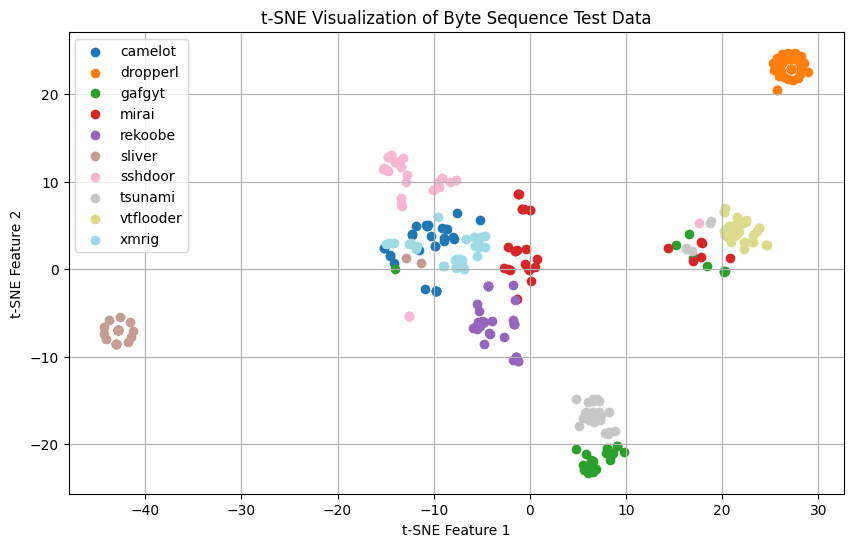

In [34]:
tsne = TSNE(n_components=2, random_state=SEED)
X_tsne = tsne.fit_transform(tfidf_matrix_test)
# 繪製t-SNE結果
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("tab20", N_WAYS)
for i in label_mapping.keys():
    plt.scatter(X_tsne[y_test == i, 0], X_tsne[y_test == i, 1], color=cmap(i), label=label_mapping[i])

plt.legend()
plt.title('t-SNE Visualization of Byte Sequence Test Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.grid(True)
plt.show()